## 自作ライブラリをGithubからクローン

In [19]:
!git clone https://github.com/urasakikeisuke/NumPyTorch.git

fatal: destination path 'NumPyTorch' already exists and is not an empty directory.


## 必要なライブラリ等をインポート

In [20]:
import os
import sys
sys.path.append('NumPyTorch')
import gzip
import warnings
warnings.simplefilter('ignore')

from urllib import request, error
from typing import Dict, List, Tuple
from time import time

import numpy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context("paper")

from tqdm.notebook import tqdm
from NumPyTorch import nn, optim
from NumPyTorch import imgaug as ia

## 設定用クラス

In [21]:
class BasicConfig(object):
    def __init__(self) -> None:
        super().__init__()

        self.EPOCHS: int = 100
        self.BATCH_SIZE: int = 100
        self.NUM_CLASSES: int = 10

        self.LEARNING_RATE: float = 1e-3
        self.DROPOUT_PROB: float = 0.5
        self.ADAM_BETAS: Tuple[float, float] = (0.9, 0.999)

        self.DATASET_BASE_URL: str = 'http://yann.lecun.com/exdb/mnist'
        self.DATASET_DICT: Dict[str, str] = {
            'train_imgs': 'train-images-idx3-ubyte.gz',
            'train_labels': 'train-labels-idx1-ubyte.gz',
            'eval_imgs': 't10k-images-idx3-ubyte.gz',
            'eval_labels': 't10k-labels-idx1-ubyte.gz'
        }
        self.DATASET_DIR: str = 'dataset'

## ネットワーク定義クラス

In [22]:
class AlelexNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        dropout_prob: float = 0.5,
    ) -> None:
        super().__init__()

        self.in_channels: int = in_channels
        self.num_classes: int = num_classes

        self.loss: float = None
        self.grads: Dict[str, numpy.ndarray] = {}

        self.conv2d_1 = nn.Conv2d(in_channels=self.in_channels, out_channels=64, kernel_size=3, stride=2, padding=1) # 28 -> 14
        # self.bn_1 = nn.BatchNorm2d(num_features=64)
        self.relu_1 = nn.ReLU(inplace=False)

        self.conv2d_2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, stride=2, padding=1) # 14 -> 7
        # self.bn_2 = nn.BatchNorm2d(num_features=192)
        self.relu_2 = nn.ReLU(inplace=False)

        self.conv2d_3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, stride=1, padding=1) # 7 -> 7
        self.relu_3 = nn.ReLU(inplace=False)

        self.conv2d_4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1) # 7 -> 7
        self.relu_4 = nn.ReLU(inplace=False)

        self.conv2d_5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1) # 7 -> 4
        # self.bn_5 = nn.BatchNorm2d(num_features=256)
        self.relu_5 = nn.ReLU(inplace=False)

        self.linear_1 = nn.Linear(in_features=256*4*4, out_features=1024)
        self.relu_6 = nn.ReLU(inplace=False)
        self.dropout_1 = nn.Dropout(p=dropout_prob)

        self.linear_2 = nn.Linear(in_features=1024, out_features=1024)
        self.relu_7 = nn.ReLU(inplace=False)
        self.dropout_2 = nn.Dropout(p=dropout_prob)

        self.linear_3 = nn.Linear(in_features=1024, out_features=self.num_classes)

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x: numpy.ndarray, training: bool) -> numpy.ndarray:
        x = self.conv2d_1(x)
        # x = self.bn_1(x)
        x = self.relu_1(x)

        x = self.conv2d_2(x)
        # x = self.bn_2(x)
        x = self.relu_2(x)

        x = self.conv2d_3(x)
        x = self.relu_3(x)

        x = self.conv2d_4(x)
        x = self.relu_4(x)

        x = self.conv2d_5(x)
        # x = self.bn_5(x)
        x = self.relu_5(x)

        x = self.linear_1(x)
        x = self.relu_6(x)
        x = self.dropout_1(x, training)

        x = self.linear_2(x)
        x = self.relu_7(x)
        x = self.dropout_2(x, training)

        x = self.linear_3(x)

        return x

    def backward(self, input: numpy.ndarray, target: numpy.ndarray) -> numpy.ndarray:
        self.loss: numpy.ndarray = self.criterion(input, target)

        dout: numpy.ndarray = 1.

        dout = self.criterion.backward(dout)

        dout = self.linear_3.backward(dout)
    
        dout = self.dropout_2.backward(dout)
        dout = self.relu_7.backward(dout)
        dout = self.linear_2.backward(dout)

        dout = self.dropout_1.backward(dout)
        dout = self.relu_6.backward(dout)
        dout = self.linear_1.backward(dout)

        dout = self.relu_5.backward(dout)
        # dout = self.bn_5.backward(dout)
        dout = self.conv2d_5.backward(dout)

        dout = self.relu_4.backward(dout)
        dout = self.conv2d_4.backward(dout)

        dout = self.relu_3.backward(dout)
        dout = self.conv2d_3.backward(dout)

        dout = self.relu_2.backward(dout)
        # dout = self.bn_2.backward(dout)
        dout = self.conv2d_2.backward(dout)

        dout = self.relu_1.backward(dout)
        # dout = self.bn_1.backward(dout)
        dout = self.conv2d_1.backward(dout)

## 学習・評価用クラス

In [23]:
class Experiment(object):
    def __init__(
        self,
        config: BasicConfig = BasicConfig()
    ) -> None:
        super().__init__()

        self.config: BasicConfig = config

        self.dataset: Dict[str, numpy.ndarray] = {}

        self.collect_dataset()

        self.dataset['train_img'] = self.dataset['train_imgs'][:1000]
        self.dataset['train_label'] = self.dataset['train_labels'][:1000]
        self.dataset['eval_img'] = self.dataset['eval_imgs'][:1000]
        self.dataset['eval_label'] = self.dataset['eval_labels'][:1000]

        self.train_num_data: int = self.dataset['train_img'].shape[0]
        self.eval_num_data: int = self.dataset['eval_img'].shape[0]
        self.train_max_steps: int = max(self.train_num_data // config.BATCH_SIZE, 1)
        self.eval_max_steps: int = max(self.eval_num_data, 1)

        self.aug: ia = ia.SomeOf(
            p=0.5,
            children=[
                ia.Identity(),
                ia.Identity(),
                ia.ShearHorizontally(ia.RandomGenerator((-10., 10.))),
                ia.ShearVertically(ia.RandomGenerator((-10., 10.))),
                ia.ShiftHorizontally(ia.RandomGenerator((-5, 5))),
                ia.ShiftVertically(ia.RandomGenerator((-5, 5))),
            ],
            random_order=True
        )

        self.net: AlelexNet = AlelexNet(
            in_channels=1, 
            num_classes=config.NUM_CLASSES, 
            dropout_prob=config.DROPOUT_PROB
        )

        self.optimizer: optim.Adam = optim.Adam(
            self.net,
            lr=config.LEARNING_RATE,
            betas=config.ADAM_BETAS,
        )

        self.loss_list: List[float] = []
        self.accuracy_list: List[float] = []

    def main_loop(self):
        for epoch_itr in range(1, self.config.EPOCHS + 1):
            with tqdm(range(1, self.train_max_steps + 1)) as pbar:
                pbar.set_description(f'Epoch {epoch_itr:5d}: {"Train":14s}')

                _losses: List[float] = []

                for _ in pbar:
                    batch_mask = numpy.random.choice(self.train_num_data, self.config.BATCH_SIZE)
                    input: numpy.ndarray = self.dataset['train_img'][batch_mask]
                    gt_label: numpy.ndarray = self.dataset['train_label'][batch_mask]

                    auged_input: numpy.ndarray = input.copy()
                    for batch in range(input.shape[0]):
                        auged_input[batch] = self.aug(input[batch])

                    output = self.net(auged_input, training=True)
                    self.net.backward(output, gt_label)

                    pbar.set_postfix({
                        'loss': f"{self.net.loss:.4f}",
                    })

                    _losses.append(self.net.loss)

                    self.optimizer.step()
                    self.optimizer.zero_grad(set_to_none=True)
                
                self.loss_list.append(numpy.mean(_losses))

            with tqdm(range(1, self.eval_max_steps + 1)) as pbar:
                pbar.set_description(f'Epoch {epoch_itr:5d}: {"Evaluation":14s}')

                accuracy: float = 0.

                for _ in pbar:
                    batch_mask = numpy.random.choice(self.dataset['eval_img'].shape[0], 1)
                    input: numpy.ndarray = self.dataset['eval_img'][batch_mask]
                    gt_label: numpy.ndarray = self.dataset['eval_label'][batch_mask]

                    output = self.net(input, training=False)

                    pred: numpy.ndarray = numpy.argmax(output, axis=1)
                    gt_label = numpy.argmax(gt_label, axis=1)

                    accuracy += numpy.sum(pred == gt_label)
                
                accuracy = accuracy * 100 / float(self.dataset["eval_img"].shape[0])
                self.accuracy_list.append(accuracy)

                print(f'{"":11s}: {"":14s}: {"Accuracy":14s}: {accuracy:8.2f} [ % ]')

    def visualize_results(self):
        fig = plt.figure()
        plt.subplots_adjust(wspace=0.4, hspace=0.6)

        ax = fig.add_subplot(2, 1, 1)
        ax.plot(list(range(1, self.config.EPOCHS + 1)), self.loss_list)
        ax.set_title("Training Loss")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Losses")
        ax.locator_params(integer=True)
        plt.show()

        fig = plt.figure()
        ax = fig.add_subplot(2, 1, 1)
        ax.plot(list(range(1, self.config.EPOCHS + 1)), self.accuracy_list)
        ax.set_title("Evaluation Accuracy")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Accuracies [%]")
        ax.locator_params(integer=True)
        plt.show()

    def collect_dataset(self):
        os.makedirs(self.config.DATASET_DIR, exist_ok=True)

        for key, value in self.config.DATASET_DICT.items():
            print(f'Downloading {key}...', end='', flush=True)

            url: str = f'{self.config.DATASET_BASE_URL}/{value}'
            file_path: str = f'{self.config.DATASET_DIR}/{value}'

            if not os.path.isfile(file_path):
                self._request(url, file_path)

            with gzip.open(file_path, 'rb') as f:
                if file_path.split('-')[1] == 'images':
                    data: numpy.ndarray = numpy.frombuffer(f.read(), numpy.uint8, offset=16)
                    data = data.reshape(-1, 784).astype(numpy.float32) / 255.
                    data = data.reshape(-1, 1, 28, 28)
                    
                elif file_path.split('-')[1] == 'labels':
                    data = numpy.frombuffer(f.read(), numpy.uint8, offset=8)
                    data = numpy.identity(10)[data]
                else:
                    raise NameError
                
                self.dataset[f'{key}'] = data

            print(f'\rDownloaded {key}')

    def _request(self, url: str, file_path: str, cnt: int = 1):
        try:
            request.urlretrieve(url, file_path)
        except error.HTTPError:
            print(f'\nFailed to download data {cnt} times. But try it again...')
            self._request(url, file_path, cnt+1)

## 学習・評価を実行

Downloaded train_imgs
Downloaded train_labels
Downloaded eval_imgs
Downloaded eval_labels



           :               : Accuracy      :    15.30 [ % ]



           :               : Accuracy      :    20.50 [ % ]



           :               : Accuracy      :    31.90 [ % ]



           :               : Accuracy      :    34.70 [ % ]



           :               : Accuracy      :    36.20 [ % ]



           :               : Accuracy      :    46.20 [ % ]



           :               : Accuracy      :    54.70 [ % ]



           :               : Accuracy      :    49.60 [ % ]



           :               : Accuracy      :    57.00 [ % ]



           :               : Accuracy      :    55.10 [ % ]



           :               : Accuracy      :    59.50 [ % ]



           :               : Accuracy      :    55.90 [ % ]



           :               : Accuracy      :    63.80 [ % ]



           :               : Accuracy      :    66.30 [ % ]



           :               : Accuracy      :    69.30 [ % ]



           :               : Accuracy      :    67.40 [ % ]



           :               : Accuracy      :    70.80 [ % ]



           :               : Accuracy      :    71.40 [ % ]



           :               : Accuracy      :    76.10 [ % ]



           :               : Accuracy      :    77.40 [ % ]



           :               : Accuracy      :    69.20 [ % ]



           :               : Accuracy      :    72.00 [ % ]



           :               : Accuracy      :    72.70 [ % ]



           :               : Accuracy      :    78.20 [ % ]



           :               : Accuracy      :    79.10 [ % ]



           :               : Accuracy      :    78.70 [ % ]



           :               : Accuracy      :    79.70 [ % ]



           :               : Accuracy      :    81.70 [ % ]



           :               : Accuracy      :    83.90 [ % ]



           :               : Accuracy      :    81.00 [ % ]



           :               : Accuracy      :    84.10 [ % ]



           :               : Accuracy      :    79.90 [ % ]



           :               : Accuracy      :    82.60 [ % ]



           :               : Accuracy      :    81.40 [ % ]



           :               : Accuracy      :    84.00 [ % ]



           :               : Accuracy      :    83.40 [ % ]



           :               : Accuracy      :    83.90 [ % ]



           :               : Accuracy      :    82.50 [ % ]



           :               : Accuracy      :    86.20 [ % ]



           :               : Accuracy      :    82.70 [ % ]



           :               : Accuracy      :    79.20 [ % ]



           :               : Accuracy      :    87.30 [ % ]



           :               : Accuracy      :    85.50 [ % ]



           :               : Accuracy      :    84.30 [ % ]



           :               : Accuracy      :    85.60 [ % ]



           :               : Accuracy      :    83.70 [ % ]



           :               : Accuracy      :    88.00 [ % ]



           :               : Accuracy      :    87.00 [ % ]



           :               : Accuracy      :    88.60 [ % ]



           :               : Accuracy      :    87.10 [ % ]



           :               : Accuracy      :    86.60 [ % ]



           :               : Accuracy      :    88.40 [ % ]



           :               : Accuracy      :    88.90 [ % ]



           :               : Accuracy      :    87.70 [ % ]



           :               : Accuracy      :    90.10 [ % ]



           :               : Accuracy      :    91.40 [ % ]



           :               : Accuracy      :    90.10 [ % ]



           :               : Accuracy      :    89.80 [ % ]



           :               : Accuracy      :    92.00 [ % ]



           :               : Accuracy      :    91.00 [ % ]



           :               : Accuracy      :    91.40 [ % ]



           :               : Accuracy      :    89.70 [ % ]



           :               : Accuracy      :    89.80 [ % ]



           :               : Accuracy      :    88.10 [ % ]



           :               : Accuracy      :    90.90 [ % ]



           :               : Accuracy      :    90.80 [ % ]



           :               : Accuracy      :    87.50 [ % ]



           :               : Accuracy      :    90.20 [ % ]



           :               : Accuracy      :    87.70 [ % ]



           :               : Accuracy      :    87.50 [ % ]



           :               : Accuracy      :    90.80 [ % ]



           :               : Accuracy      :    89.30 [ % ]



           :               : Accuracy      :    92.10 [ % ]



           :               : Accuracy      :    90.30 [ % ]



           :               : Accuracy      :    91.00 [ % ]



           :               : Accuracy      :    87.20 [ % ]



           :               : Accuracy      :    89.80 [ % ]



           :               : Accuracy      :    90.90 [ % ]



           :               : Accuracy      :    88.40 [ % ]



           :               : Accuracy      :    91.70 [ % ]



           :               : Accuracy      :    88.50 [ % ]



           :               : Accuracy      :    92.60 [ % ]



           :               : Accuracy      :    89.40 [ % ]



           :               : Accuracy      :    90.10 [ % ]



           :               : Accuracy      :    89.30 [ % ]



           :               : Accuracy      :    89.70 [ % ]



           :               : Accuracy      :    91.60 [ % ]



           :               : Accuracy      :    90.70 [ % ]



           :               : Accuracy      :    90.00 [ % ]



           :               : Accuracy      :    91.30 [ % ]



           :               : Accuracy      :    88.10 [ % ]



           :               : Accuracy      :    90.90 [ % ]



           :               : Accuracy      :    90.50 [ % ]



           :               : Accuracy      :    89.40 [ % ]



           :               : Accuracy      :    90.50 [ % ]



           :               : Accuracy      :    91.10 [ % ]



           :               : Accuracy      :    89.90 [ % ]



           :               : Accuracy      :    91.70 [ % ]



           :               : Accuracy      :    89.40 [ % ]



           :               : Accuracy      :    89.50 [ % ]


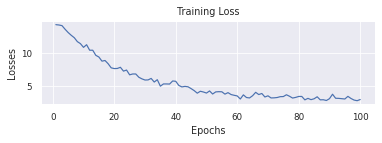

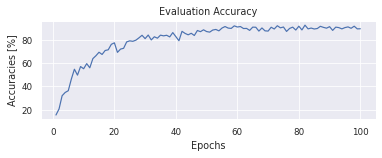

In [24]:
exp: Experiment = Experiment()
exp.main_loop()
exp.visualize_results()